In [1]:
%matplotlib inline
%config InlineBackend.figure_format = "png2x"

from __future__ import print_function

import warnings
warnings.filterwarnings('ignore')

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams

In [2]:
rcParams["savefig.dpi"] = 200
rcParams["figure.dpi"] = 200
rcParams["font.size"] = 20
rcParams["figure.figsize"] = [8, 5]
rcParams["font.family"] = "sans-serif"
rcParams["font.sans-serif"] = ["Computer Modern Sans Serif"]
rcParams["text.usetex"] = True

# Degrading a Spectrum to Lower Resolution



In [3]:
import coronagraph as cg
print(cg.__version__)

1.0


### Proxima Centauri Stellar Spectrum

First, let's grab the stellar spectral energy distribution (SED) of Proxima Centauri from the VPL website: 

In [4]:
# The file is located at the following URL:
url = "http://vpl.astro.washington.edu/spectra/stellar/proxima_cen_sed.txt"

# We can open the URL with the following 
import urllib.request
response = urllib.request.urlopen(url)

# Read file lines
data = response.readlines()

# Remove header and extraneous info
tmp = np.array([np.array(str(d).split("\\")) for d in data[25:]])[:,[1,2]]

# Extract columns
lam = np.array([float(d[1:]) for d in tmp[:,0]])
flux = np.array([float(d[1:]) for d in tmp[:,1]])

Now let's set the min and max for our low res wavelength grid, use `construct_lam` to create the low-res wavelength grid, use `downbin_spec` to make a low-res spectrum, and plot it. 

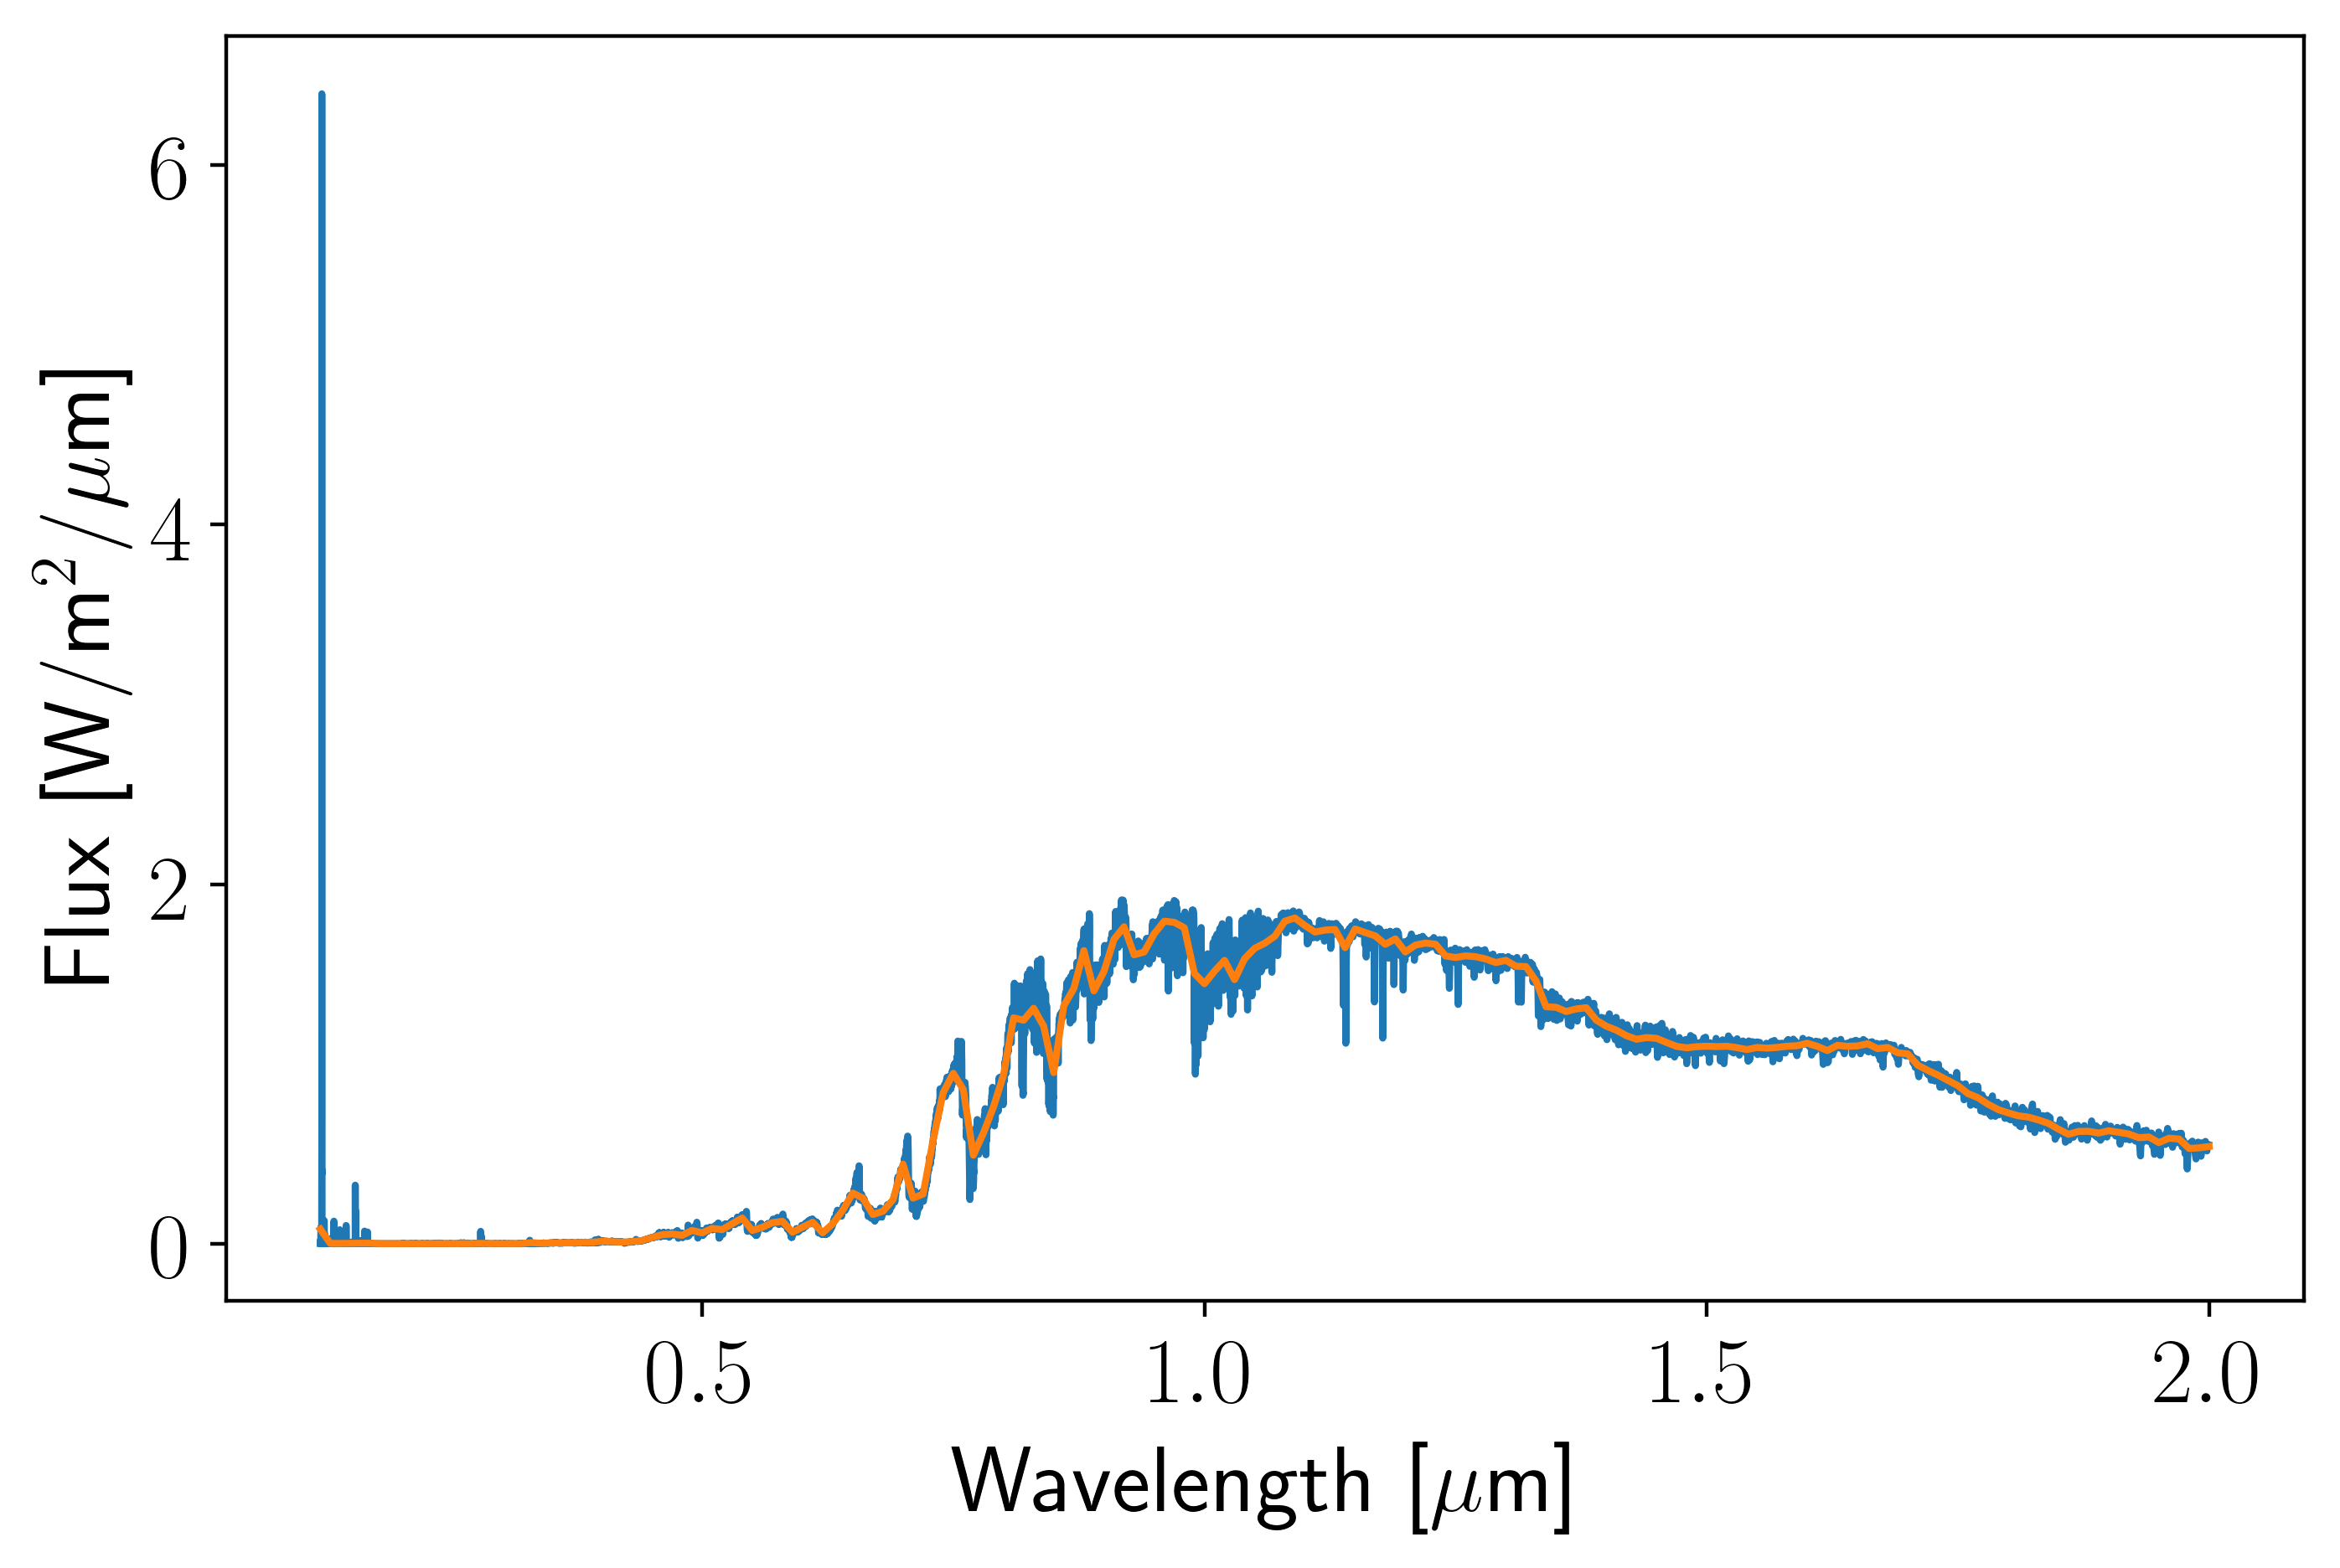

In [5]:
# Set the wavelength and resolution parameters
lammin = 0.12
lammax = 2.0
R = 200
dl = 0.01

# Construct new low-res wavelength grid
wl, dwl = cg.noise_routines.construct_lam(lammin, lammax, dlam = dl)

# Down-bin flux to low-res
flr = cg.downbin_spec(flux, lam, wl, dlam=dwl)

# Plot
m = (lam > lammin) & (lam < lammax)
plt.plot(lam[m], flux[m])
plt.plot(wl, flr)
#plt.yscale("log")
plt.xlabel(r"Wavelength [$\mu$m]")
plt.ylabel(r"Flux [W/m$^2$/$\mu$m]");

NaNs can occur when no high-resolution values exist within a given lower-resolution bein. How many NaNs are there?

In [6]:
print(np.sum(~np.isfinite(flr)))

0


Let's try it again now focusing on the UV with a higher resolution.

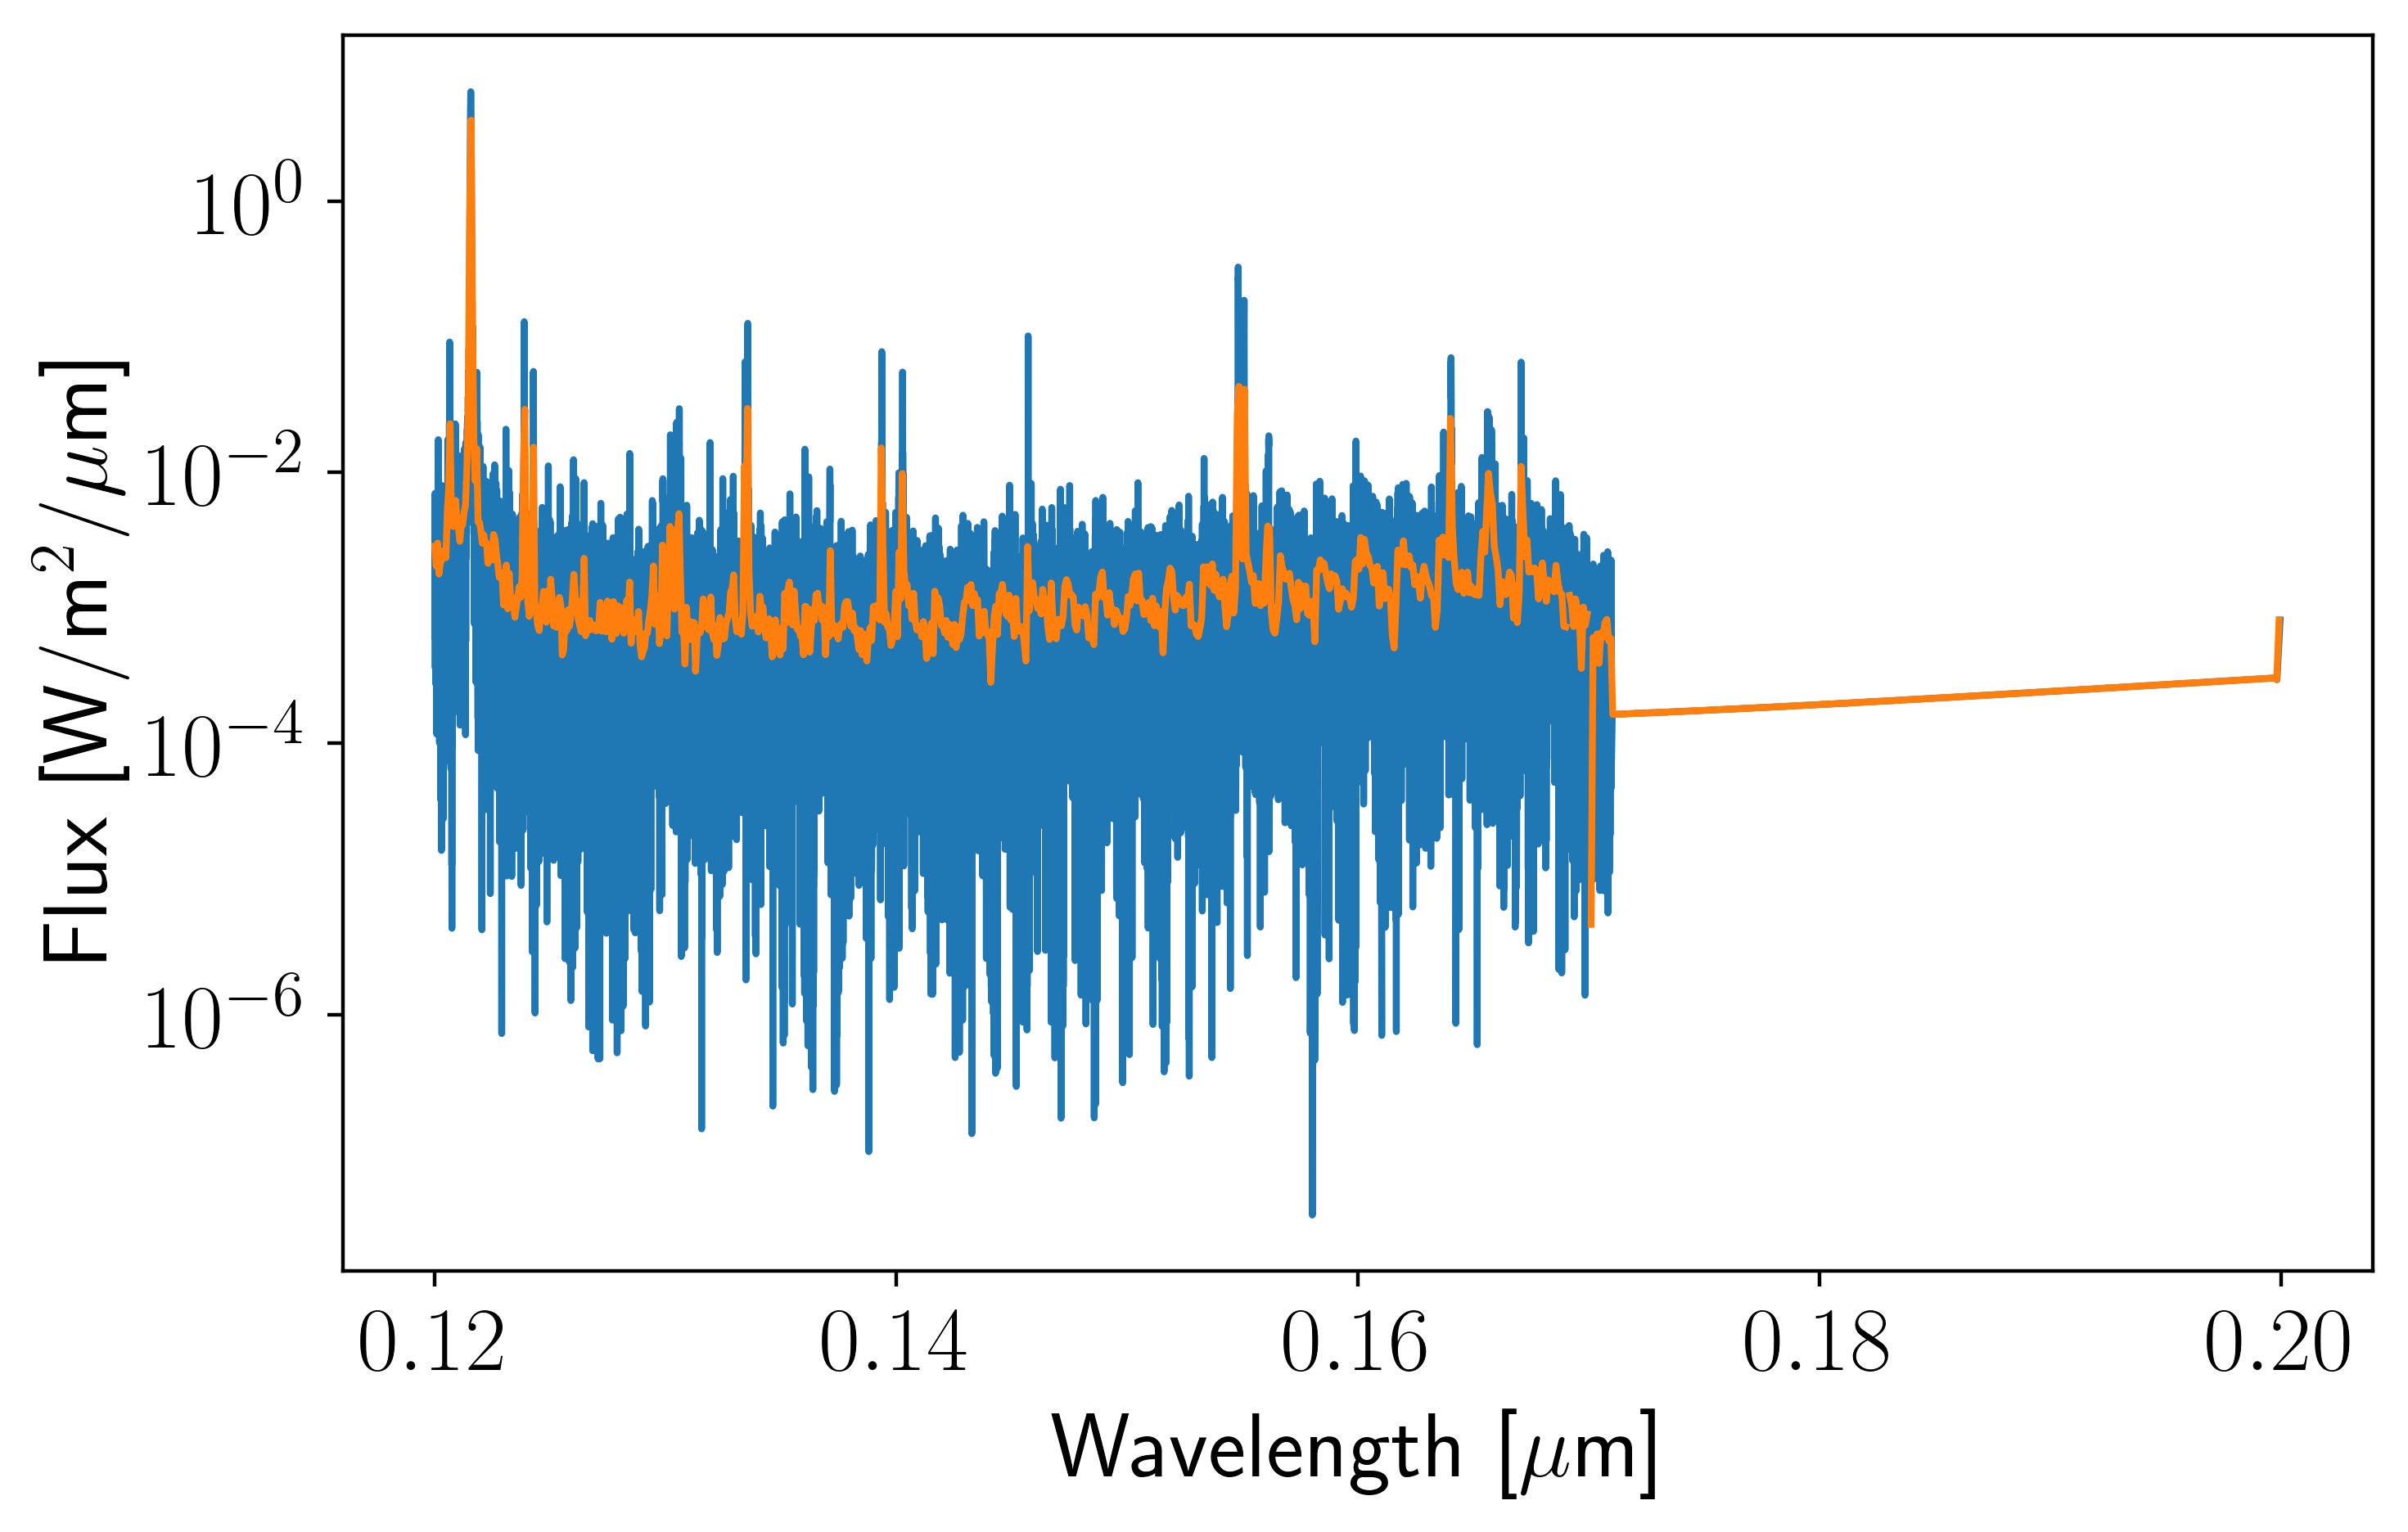

In [7]:
# Set the wavelength and resolution parameters
lammin = 0.12
lammax = 0.2
R = 2000

# Construct new low-res wavelength grid
wl, dwl = cg.noise_routines.construct_lam(lammin, lammax, R)

# Down-bin flux to low-res
flr = cg.downbin_spec(flux, lam, wl, dlam=dwl)

# Plot
m = (lam > lammin) & (lam < lammax)
plt.plot(lam[m], flux[m])
plt.plot(wl, flr)
plt.yscale("log")
plt.xlabel(r"Wavelength [$\mu$m]")
plt.ylabel(r"Flux [W/m$^2$/$\mu$m]");

In [8]:
print(np.sum(~np.isfinite(flr)))

26


### Optimal Resolution for Observing Earth's O$_2$ A-band  

Let's load in the Earth's reflectance spectrum [(Robinson et al., 2011)](http://adsabs.harvard.edu/abs/2011AsBio..11..393R).

In [4]:
lamhr, Ahr, fstar = cg.get_earth_reflect_spectrum()

Now let's isolate just the O$_2$ A-band.

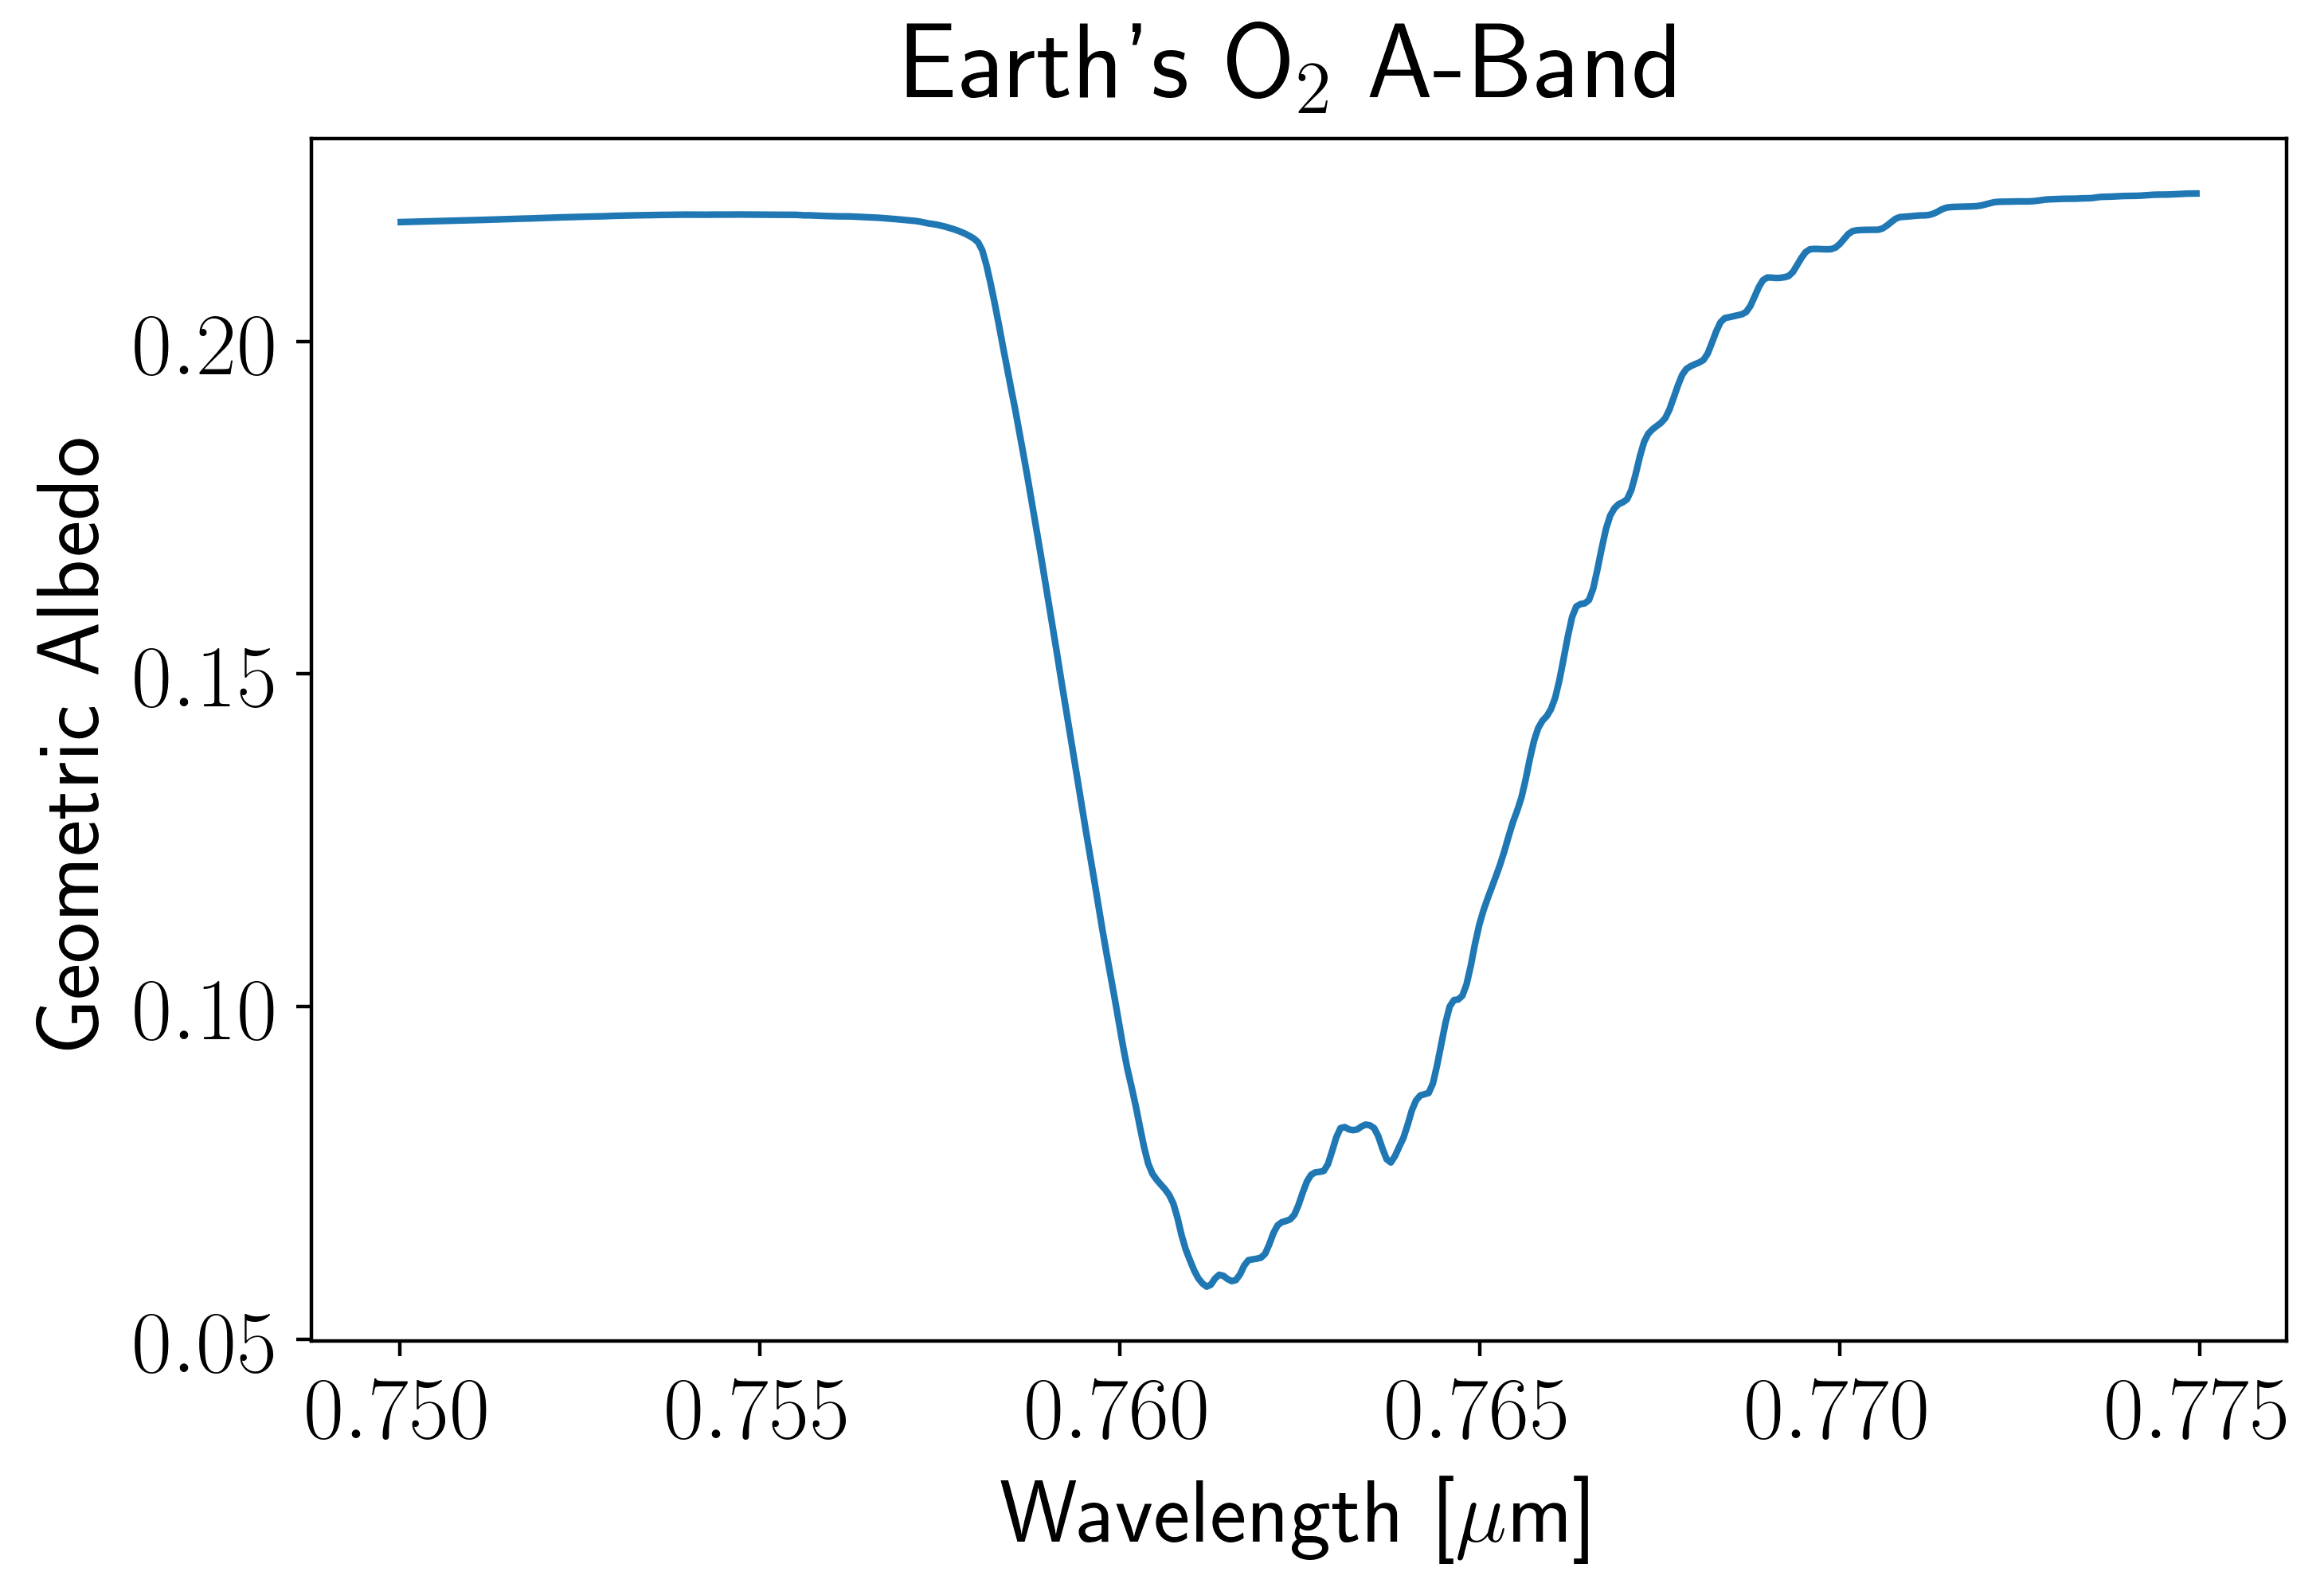

In [5]:
lammin = 0.750
lammax = 0.775

# Create a wavelength mask
m = (lamhr > lammin) & (lamhr < lammax)

# Plot the band
plt.plot(lamhr[m], Ahr[m])
plt.xlabel(r"Wavelength [$\mu$m]")
plt.ylabel("Geometric Albedo")
plt.title(r"Earth's O$_2$ A-Band");

Define a set of resolving powers for us to loop over.

In [6]:
R = np.array([1, 10, 30, 70, 100, 150, 200, 500, 1000])

Let's down-bin the high-res spectrum at each `R`. For each `R` in the loop we will construct a new wavelength grid, down-bin the high-res spectrum, and plot the degraded spectrum. Let's also save the minimum value in the degraded spectrum to assess how close we get to the actual bottom of the band.  

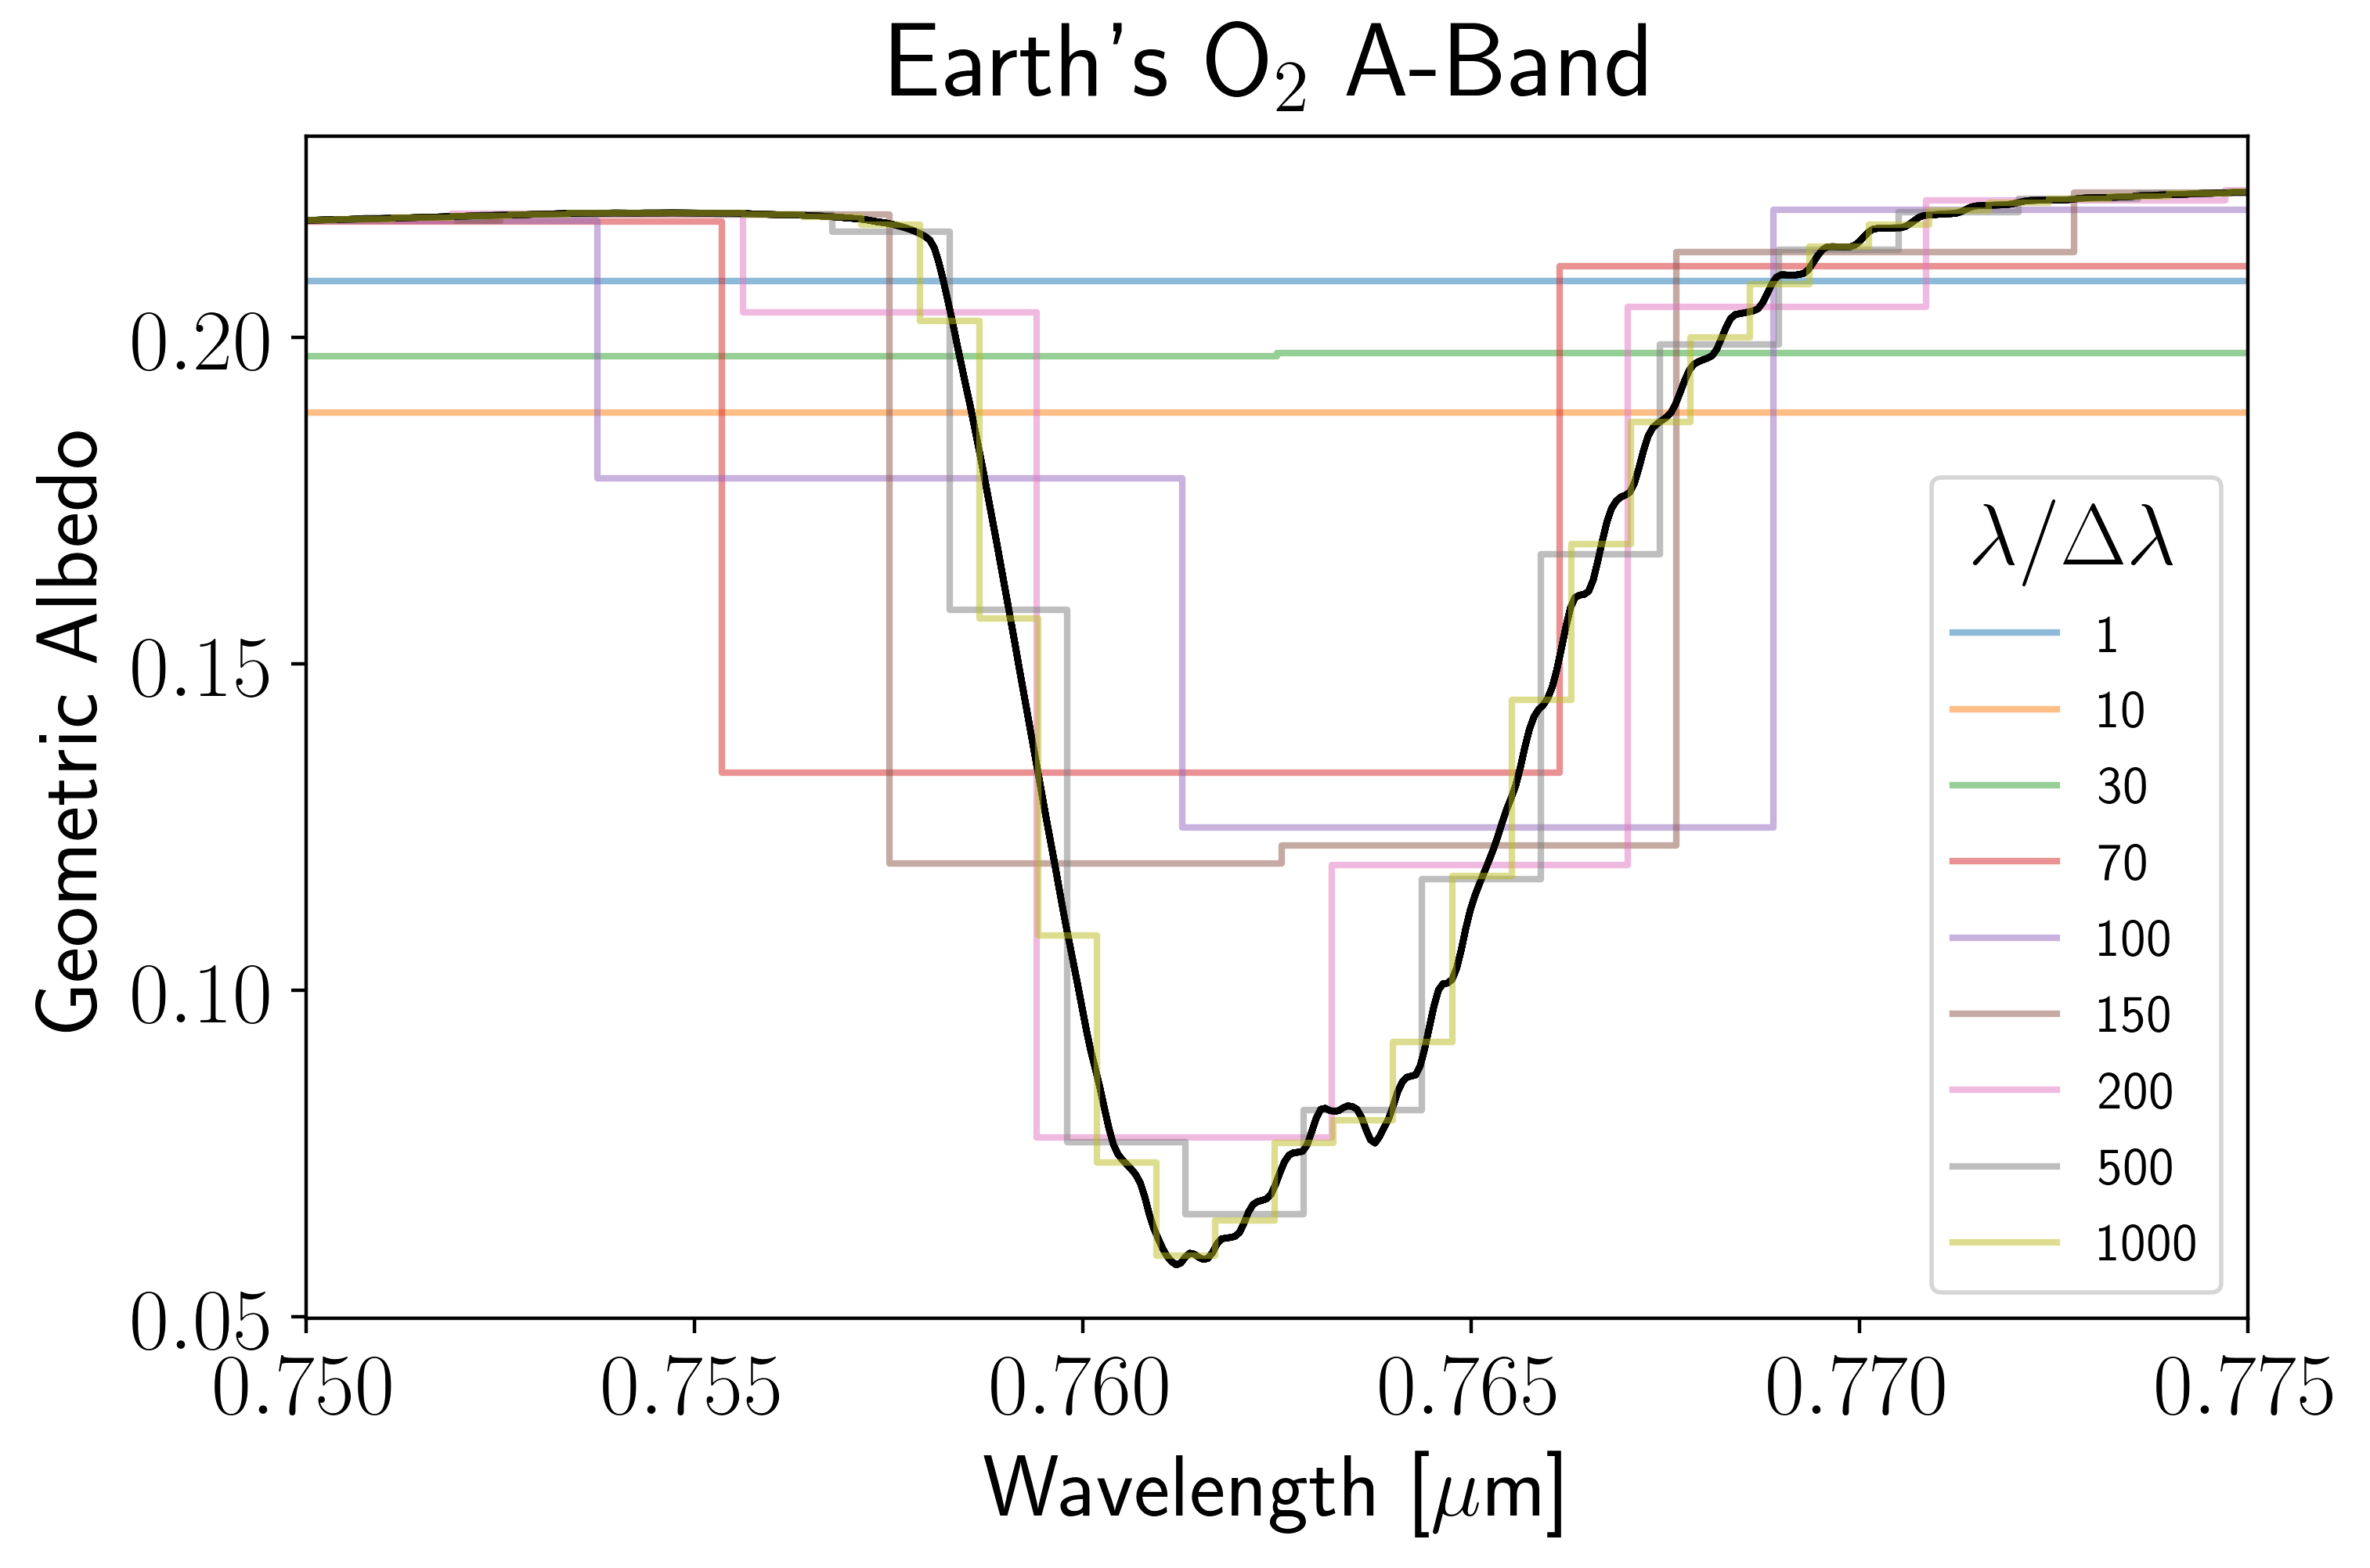

In [7]:
bottom_val = np.zeros(len(R))

# Loop over R
for i, r in enumerate(R):
    
    # Construct new low-res wavelength grid
    wl, dwl = cg.noise_routines.construct_lam(lammin, lammax, r)

    # Down-bin flux to low-res
    Alr = cg.downbin_spec(Ahr, lamhr, wl, dlam=dwl)
    
    # Plot 
    plt.plot(wl, Alr, ls = "steps-mid", alpha = 0.5, label = "%i" %r)
    
    # Save bottom value
    bottom_val[i] = np.min(Alr)

# Finsh plot
plt.plot(lamhr[m], Ahr[m], c = "k")
plt.xlim(lammin, lammax)
plt.legend(fontsize = 12, title = r"$\lambda / \Delta \lambda$")
plt.xlabel(r"Wavelength [$\mu$m]")
plt.ylabel("Geometric Albedo")
plt.title(r"Earth's O$_2$ A-Band");

We can now compare the bottom value in low-res spectra to the bottom of the high-res spectrum.  

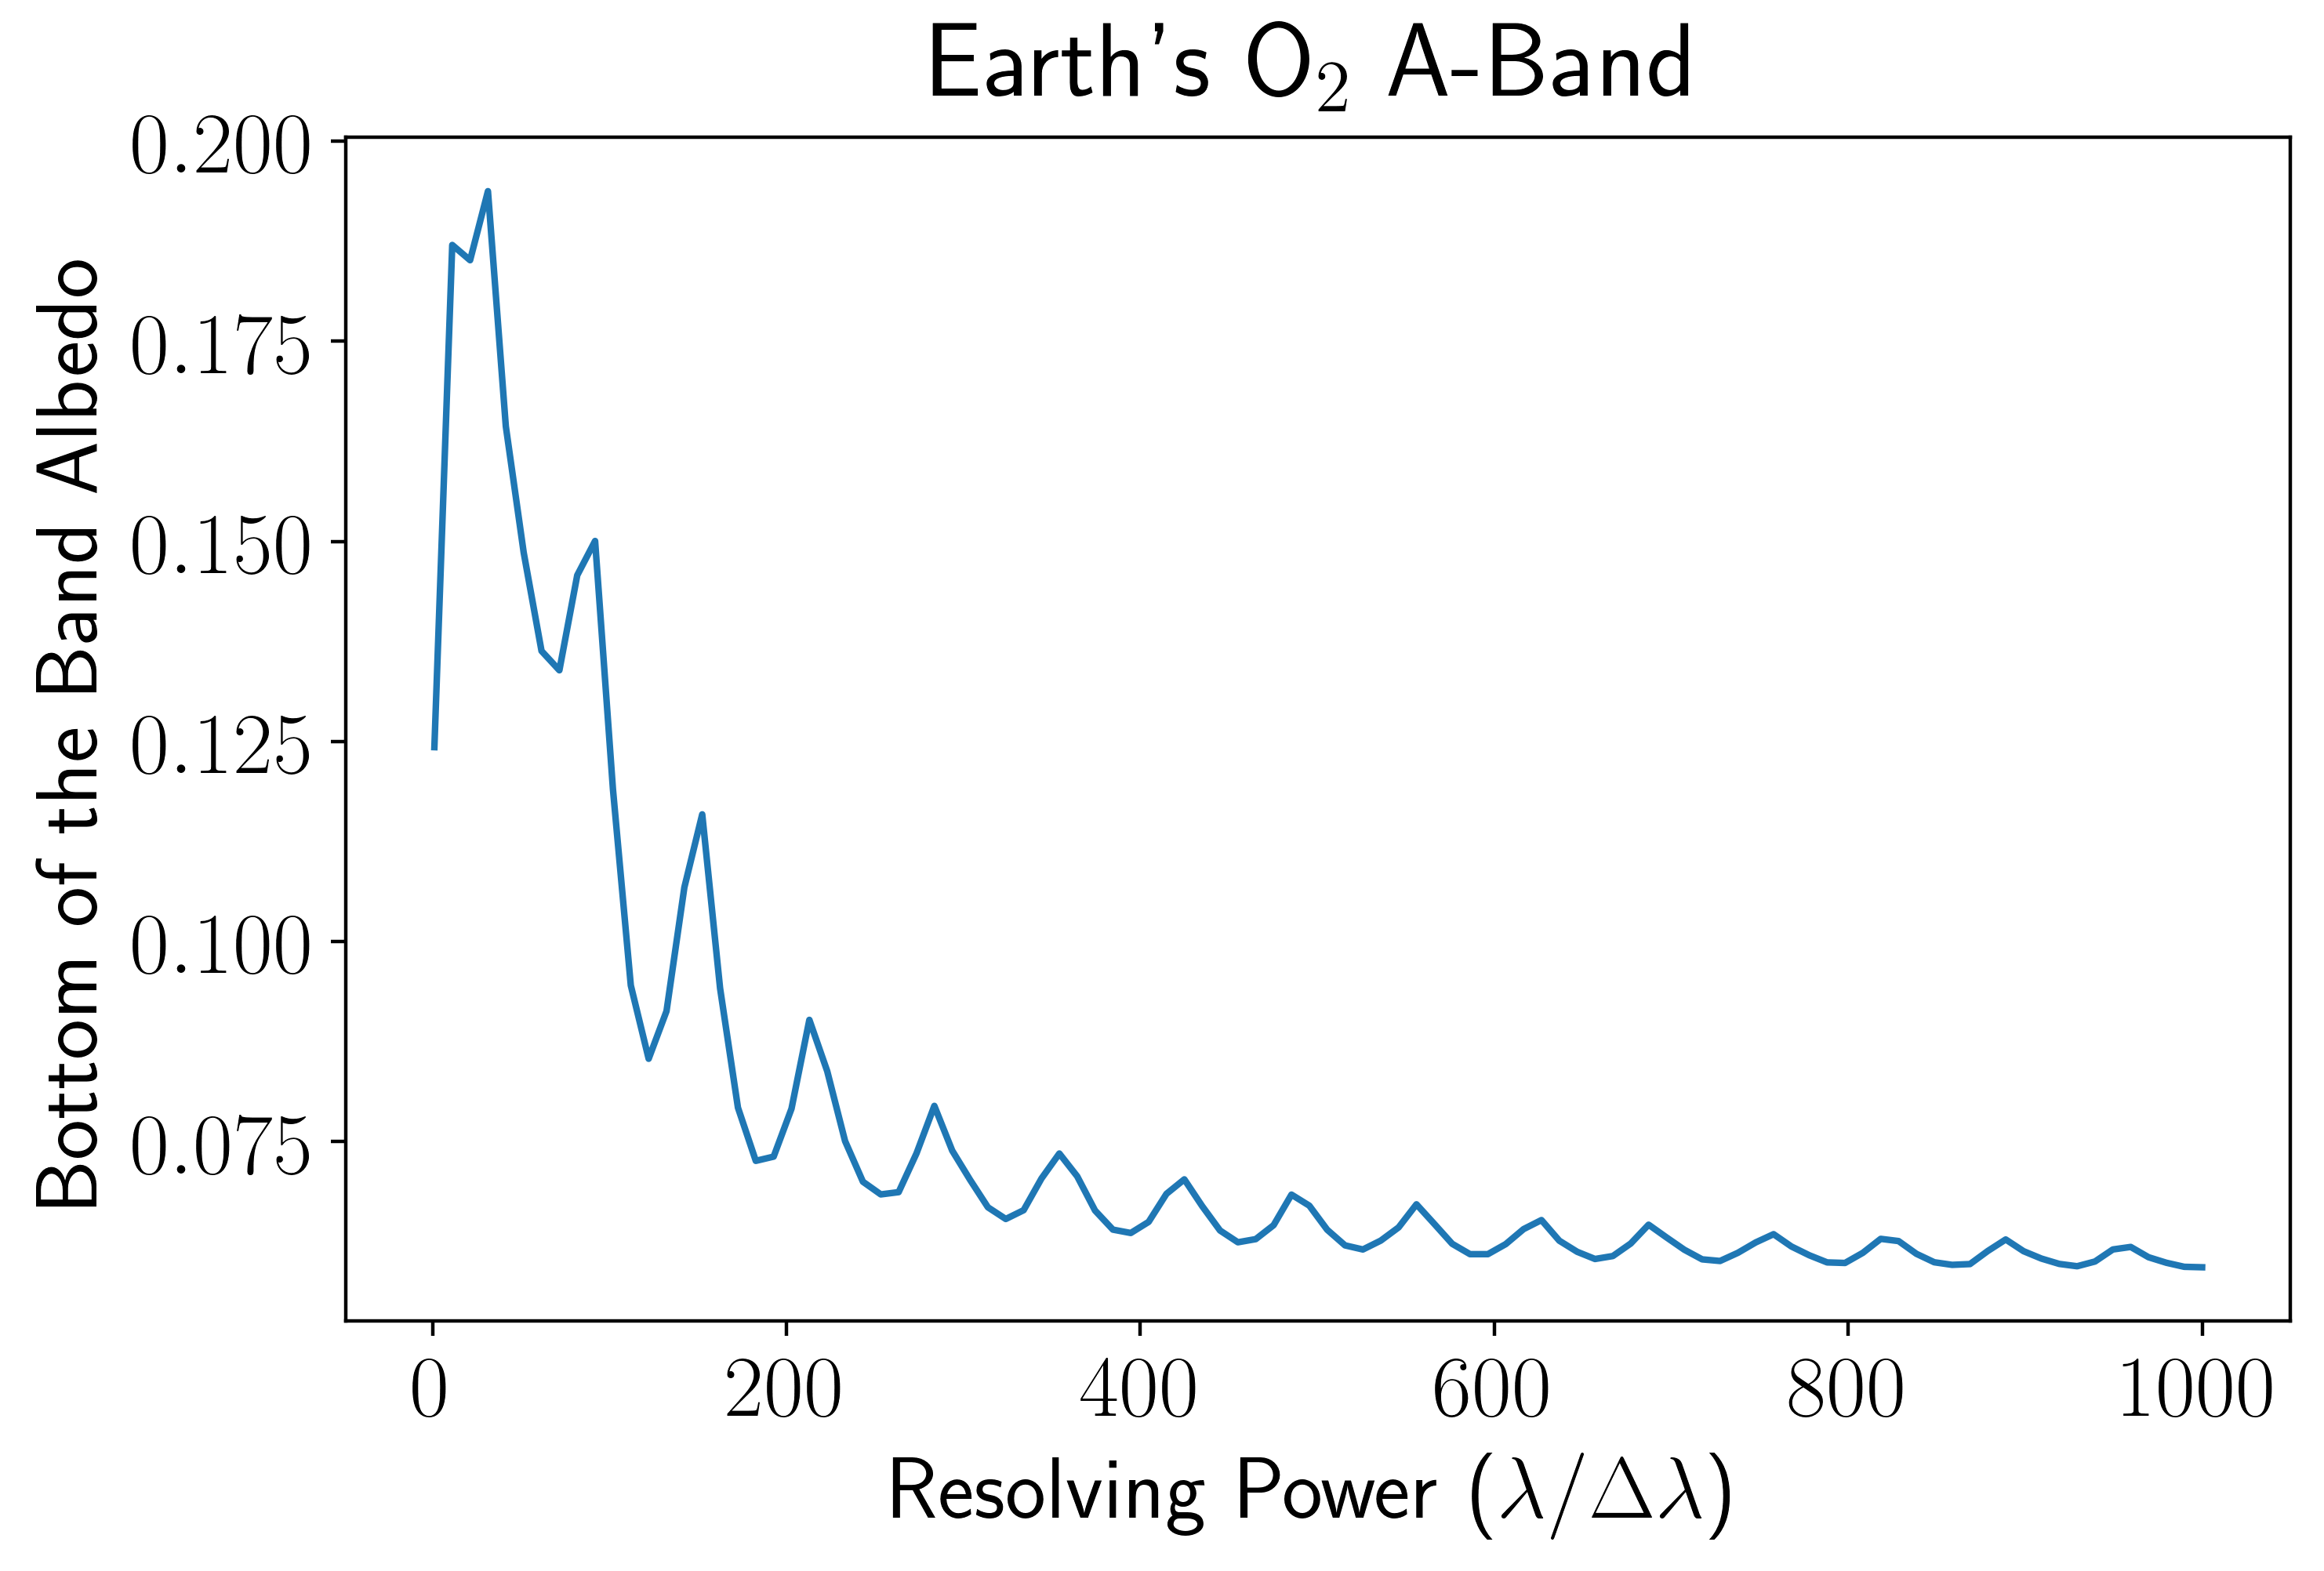

In [68]:
# Create resolution array to loop over
Nres = 100
R = np.linspace(1,1000, Nres)

# Array to store bottom-of-band albedos 
bottom_val = np.zeros(len(R))

# Loop over R
for i, r in enumerate(R): 
    
    # Construct new low-res wavelength grid
    wl, dwl = cg.noise_routines.construct_lam(lammin, lammax, r)
    
    # Down-bin flux to low-res
    Alr = cg.downbin_spec(Ahr, lamhr, wl, dlam=dwl) 
    
    # Save bottom value
    bottom_val[i] = np.min(Alr)

# Make plot
plt.plot(R, bottom_val);
plt.xlabel(r"Resolving Power ($\lambda / \Delta \lambda$)")
plt.ylabel("Bottom of the Band Albedo")
plt.title(r"Earth's O$_2$ A-Band");

The oscillations in the above plot are the result of non-optimal placement of the resolution element relative to the oxygen A-band central wavelength. We can do better than this by iterating over different minimum wavelength positions. 

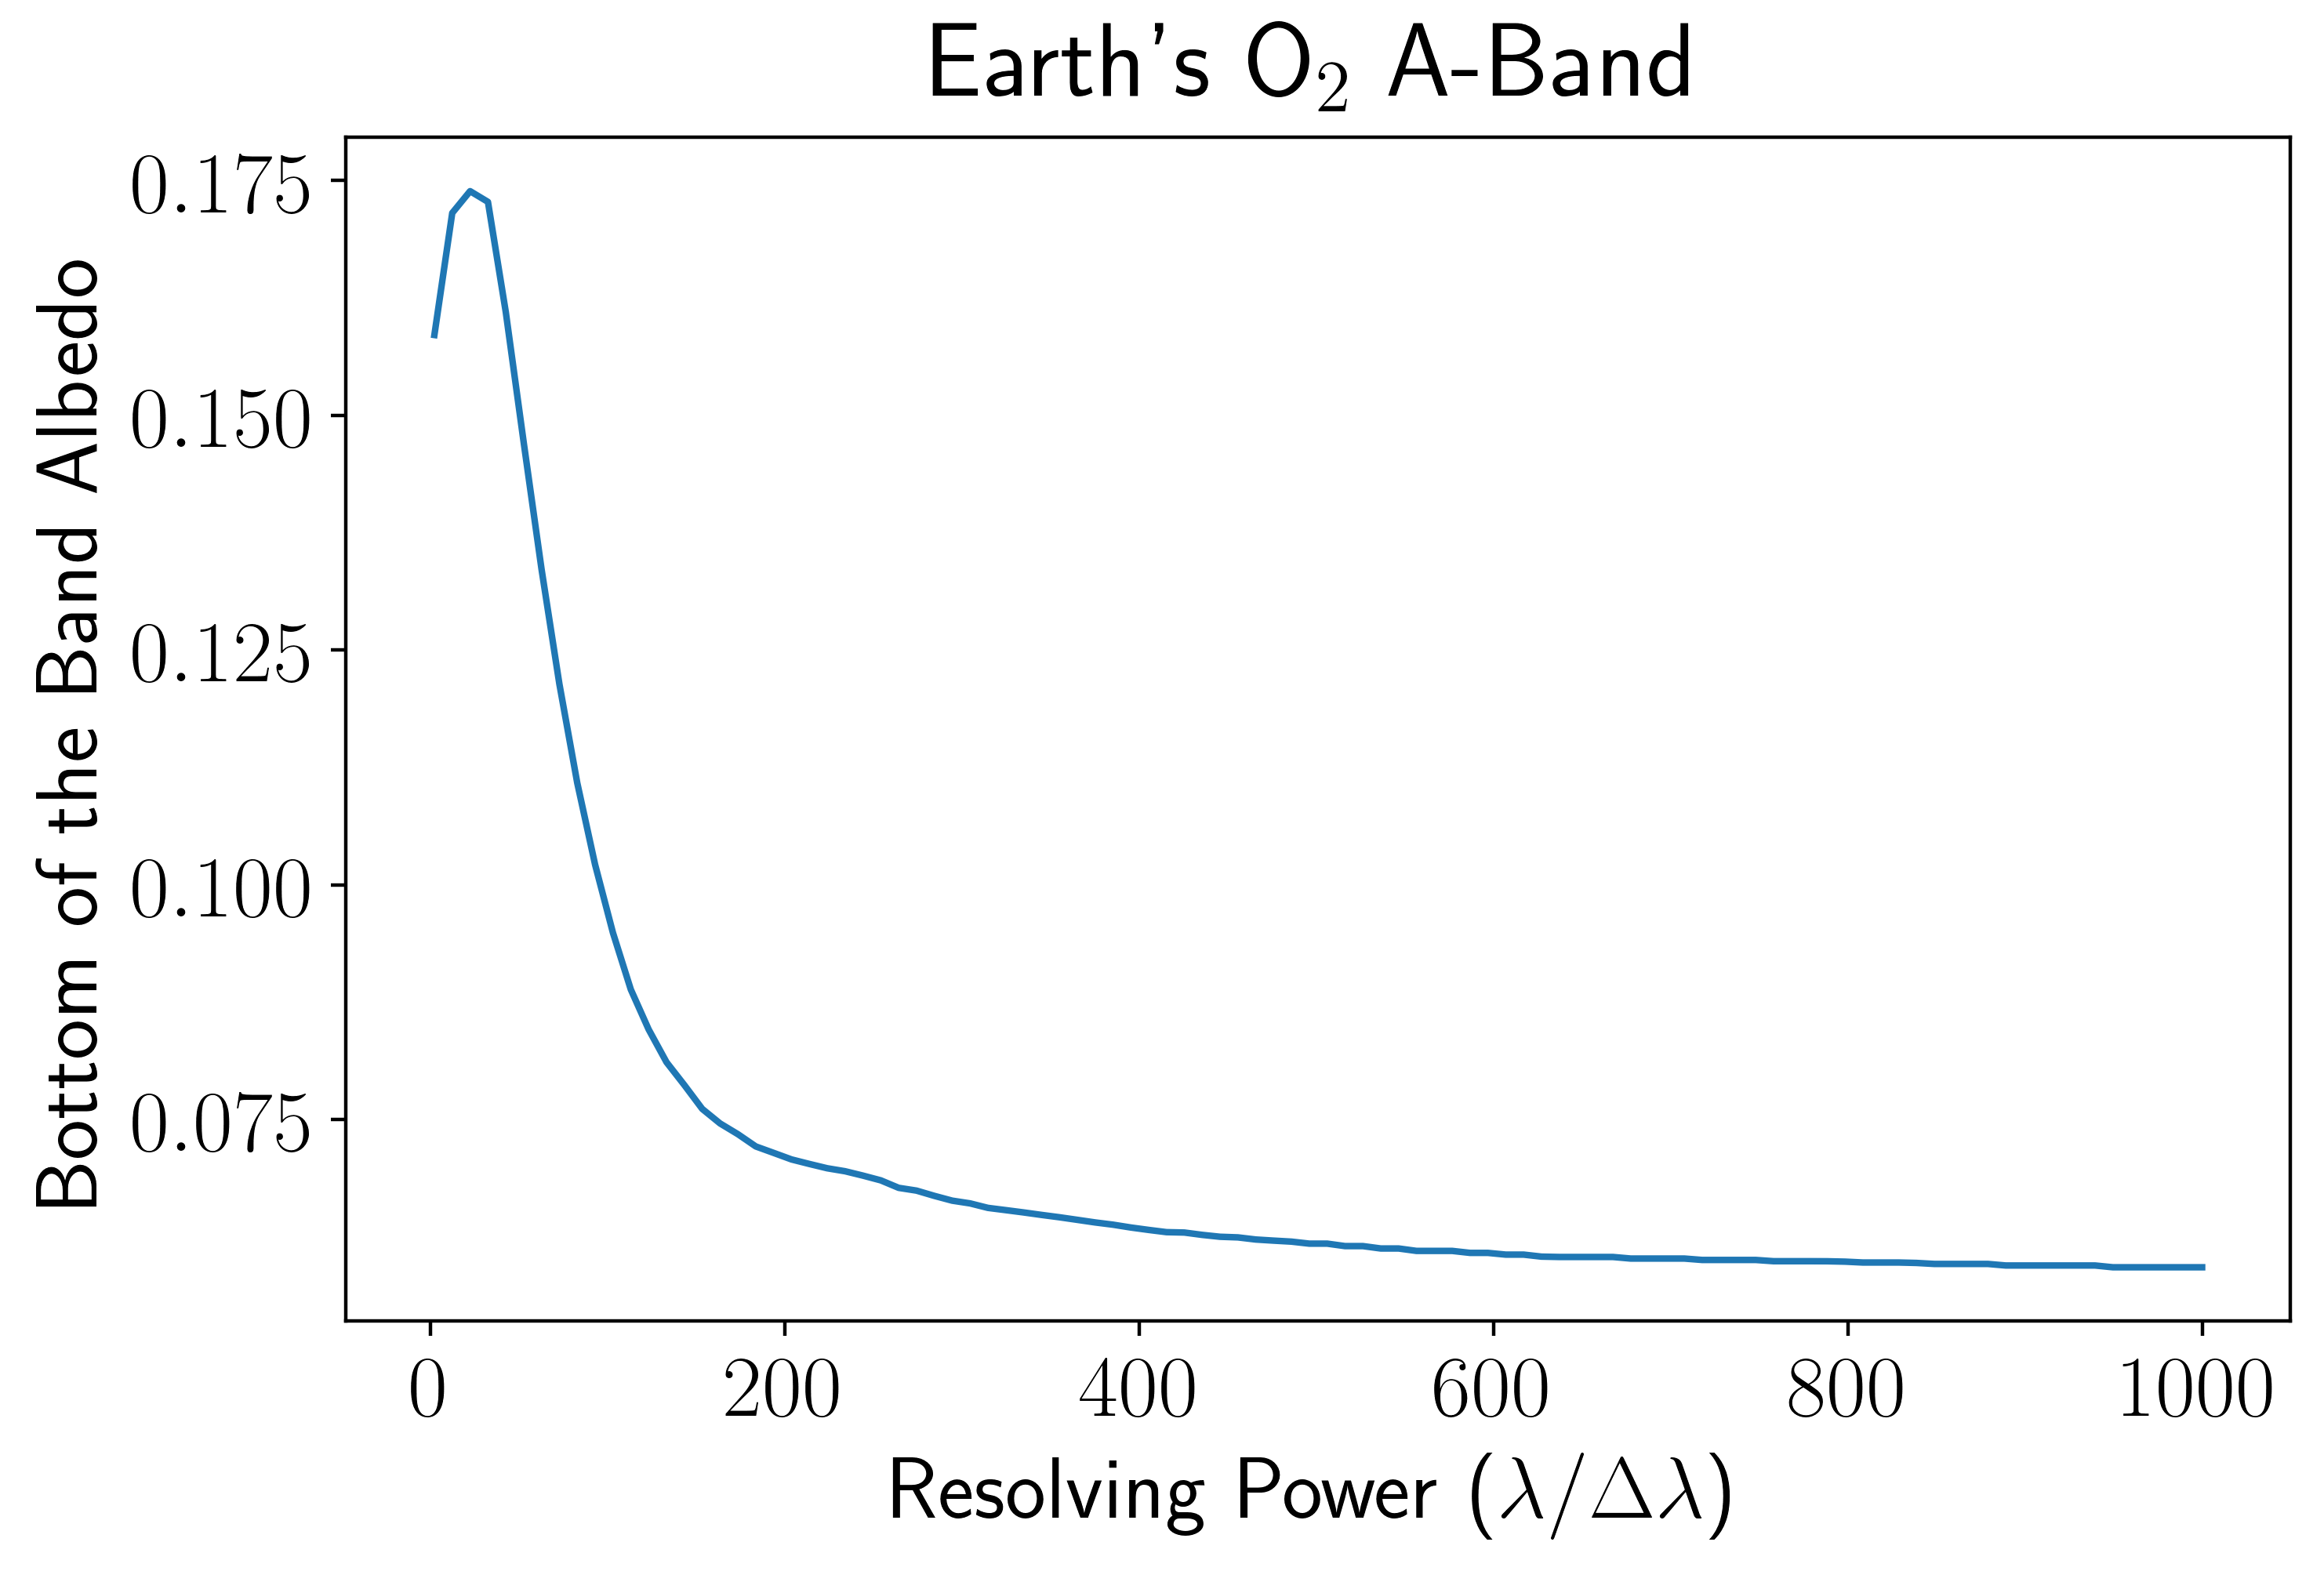

In [183]:
# Create resolution array to loop over
Nres = 100
R = np.linspace(2,1000, Nres)

# Set number of initial positions
Ntest = 20

# Arrays to save quantities
bottom_vals = np.nan*np.zeros([len(R), Ntest])
best = np.nan*np.zeros(len(R), dtype=int)
Alrs = []
lams = []

# Loop over R
for i, r in enumerate(R): 
    
    # Set grid of minimum wavelengths to iterate over
    lammin_vals = np.linspace(lammin - 1.0*0.76/r, lammin, Ntest)
        
    # Loop over minimum wavelengths to adjust bin centers
    for j, lmin in enumerate(lammin_vals):

        # Construct new low-res wavelength grid
        wl, dwl = cg.noise_routines.construct_lam(lmin, lammax, r)
        
        # Down-bin flux to low-res
        Alr = cg.downbin_spec(Ahr, lamhr, wl, dlam=dwl) 
        
        # Keep track of the minimum
        if ~np.isfinite(best[i]) or (np.nansum(np.min(Alr) < bottom_vals[i,:]) > 0):
            best[i] = j
        
        # Save quantities
        bottom_vals[i,j] = np.min(Alr)
        Alrs.append(Alr)
        lams.append(wl)
            
# Reshape saved arrays
Alrs = np.array(Alrs).reshape((Ntest, Nres), order = 'F')
lams = np.array(lams).reshape((Ntest, Nres), order = 'F')
best =  np.array(best, dtype=int)

# Plot the global minimum 
plt.plot(R, np.min(bottom_vals, axis = 1));
plt.xlabel(r"Resolving Power ($\lambda / \Delta \lambda$)")
plt.ylabel("Bottom of the Band Albedo")
plt.title(r"Earth's O$_2$ A-Band");

In the above plot we are looking at the minimum albedo of the oxygen A-band *after optimizing the central band location*, and we can see that the pesky oscillations are now gone. 
At low resolution the above curve quickly decays as less and less continuum is mixed into the band measurement, while at high resolution the curve asymptotes to the true minimum of the band. 

Essentially what we have done is ensure that, when possible, the oxygen band is not split between multiple spectral elements. This can be seen in the following plot, which samples a few of the optimal solutions. It doesn't look too different from the first version of this plot, but it does more efficiently sample the band shape (note that the lower resolution spectra have deeper bottoms and more tightly capture the band wings). 

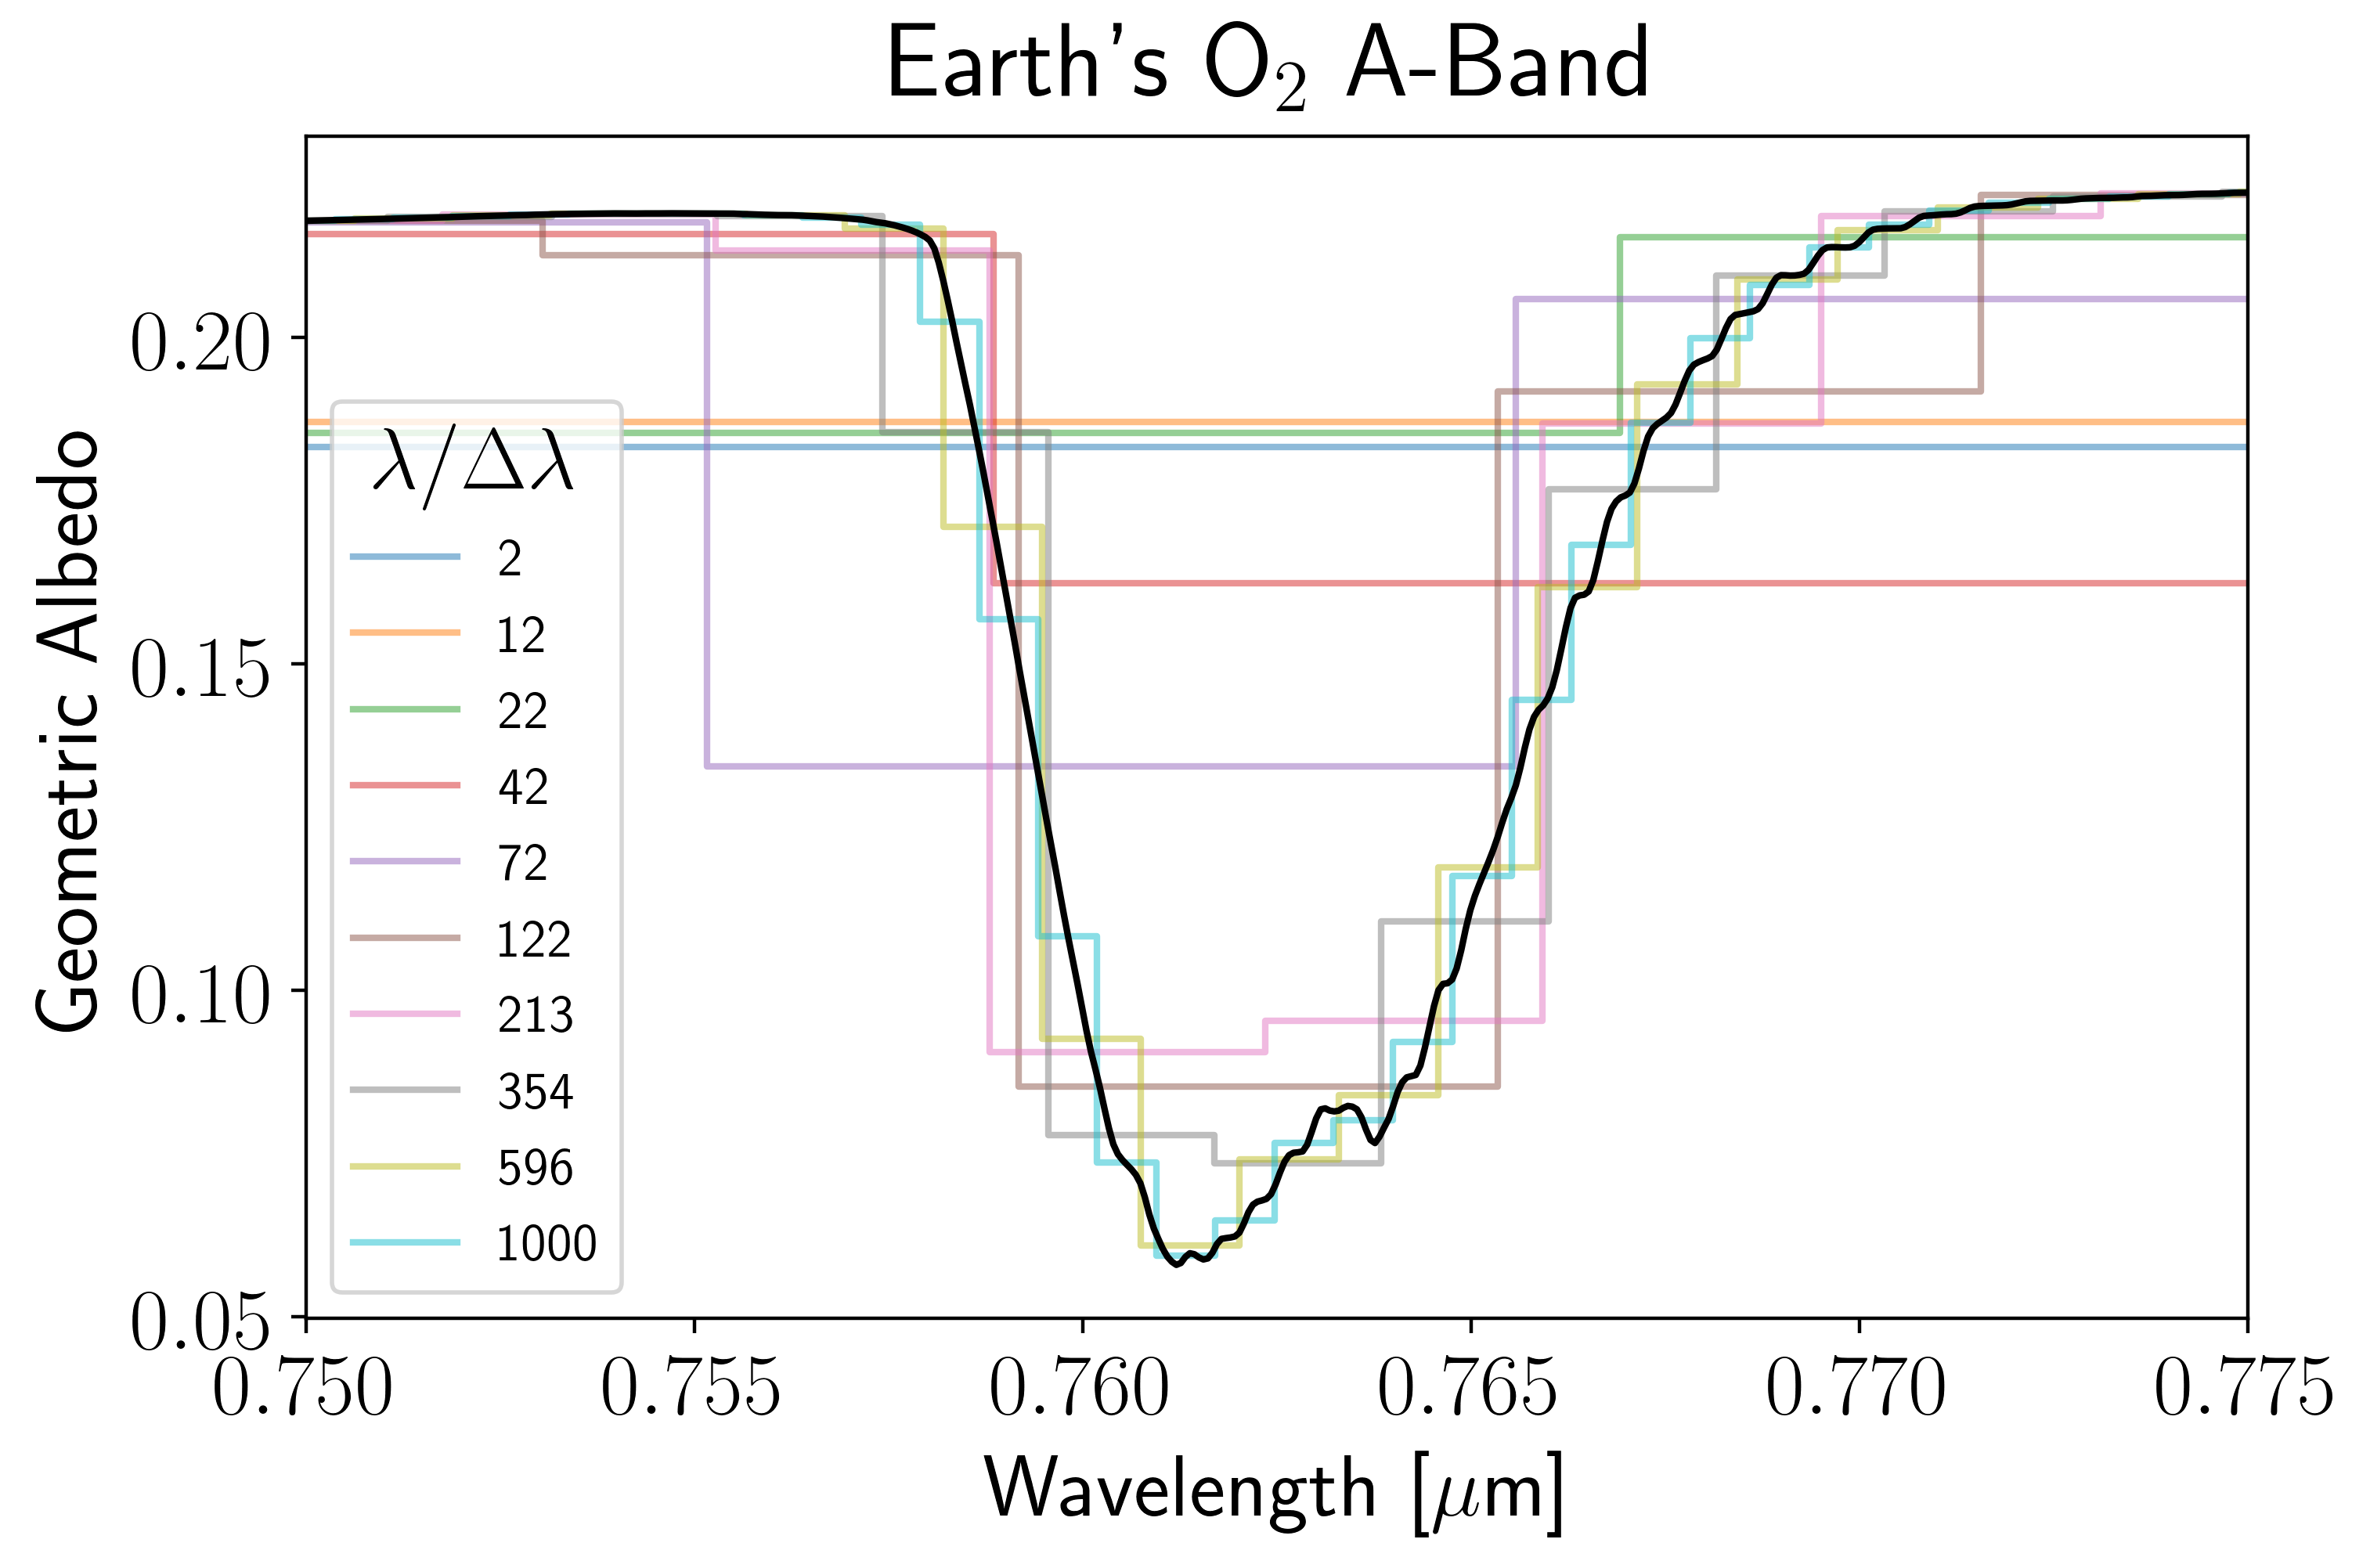

In [186]:
# Get some log-spaced indices so we're not plotting all R
iz = np.array(np.logspace(np.log10(1), np.log10(100), 10).round(), dtype=int) - 1

# Loop over R
for i, r in enumerate(R):
    
    # Plot some of the resolutions
    if i in iz:
        plt.plot(b[best[i], i], a[best[i], i], ls = "steps-mid", alpha = 0.5, label = "%i" %r)
        plt.xlim(lammin, lammax)

# Finsh plot
plt.plot(lamhr[m], Ahr[m], c = "k")
plt.legend(fontsize = 12, title = r"$\lambda / \Delta \lambda$")
plt.xlabel(r"Wavelength [$\mu$m]")
plt.ylabel("Geometric Albedo")
plt.title(r"Earth's O$_2$ A-Band");

As you can see, much can be done with the simple re-binning functions, but the true utility of the `coronagraph` model comes from the noise calculations. Please refer to the other tutorials and examples for more details! 